In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from binance import Client
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import sys
import ta
# from data import get_data
sys.path.insert(1, '/home/kenny/algotrading/backtesting')
from backtest import * 
from strategies import *
from config import *
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")
print(sys.path)

/home/kenny/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['/home/kenny/algotrading/model_training', '/home/kenny/algotrading/backtesting', '/home/kenny/miniconda3/envs/algotrading/lib/python310.zip', '/home/kenny/miniconda3/envs/algotrading/lib/python3.10', '/home/kenny/miniconda3/envs/algotrading/lib/python3.10/lib-dynload', '', '/home/kenny/.local/lib/python3.10/site-packages', '/home/kenny/miniconda3/envs/algotrading/lib/python3.10/site-packages']


In [66]:
url = config.DATABASE_URL_1MINUTE
time_frame = config.INTERVAL_1MINUTE
td_days = 0

In [8]:
client = Client()
engine = create_engine(url=url)

NameError: name 'url' is not defined

In [ ]:
symbol = 'BTCUSDT'
data = get_data(symbol)

In [68]:
# with engine.connect() as connection:
#     query = "SELECT name FROM sqlite_schema WHERE type='table'"
#     symbols = [item[0] for item in connection.execute(text(query)).fetchall()]
#     # for symbol in symbols:
#     #     qry = f"SELECT * FROM '{symbol}' WHERE Open_Time < '{pd.to_datetime('today') - timedelta(days = td_days)}'"
#     #     data = pd.DataFrame(connection.execute(text(qry))).set_index("Open_Time")
#     #     data.index = pd.to_datetime(data.index)
#     symbol = symbols[0]
#     qry = f"SELECT * FROM '{symbol}' WHERE Open_Time < '{pd.to_datetime('today') - timedelta(days = td_days)}'"
#     data = pd.DataFrame(connection.execute(text(qry))).set_index("Open_Time")
#     data.index = pd.to_datetime(data.index)

# connection.close()

# print(symbol)
# data

In [69]:
# data.plot(style='.',
#         figsize=(15, 5),
#         color=color_pal[0],
#         title='SOLUSDT')
# plt.show()

In [70]:
# fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

# fold = 0
# for train_idx, val_idx in tss.split(df):
#     train = data.iloc[train_idx]
#     test = data.iloc[val_idx]
#     train['Close'].plot(ax=axs[fold],
#                           label='Training Set',
#                           title=f'Data Train/Test Split Fold {fold}')
#     test['Close'].plot(ax=axs[fold],
#                          label='Test Set')
#     axs[fold].axvline(test.index.min(), color='black', ls='--')
#     fold += 1
# plt.show()

In [9]:
symbol = 'BTCUSDT'
data = get_data(symbol)

In [73]:
data.head()

,Open,High,Low,Close,Volume
Time,,,,,
2023-01-08 21:42:00,13.81,13.83,13.80,13.80,1661.56
2023-01-08 21:43:00,13.80,13.81,13.79,13.80,863.28
2023-01-08 21:44:00,13.79,13.81,13.79,13.80,1730.60
2023-01-08 21:45:00,13.80,13.83,13.79,13.81,4006.07
2023-01-08 21:46:00,13.82,13.84,13.81,13.81,6932.46


In [6]:
data.describe()

,Open,High,Low,Close,Volume
count,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000
mean,22.409604,22.431721,22.387541,22.409084,5048.014101
std,2.644143,2.644212,2.642857,2.644272,10958.059426
min,13.690000,13.700000,13.680000,13.680000,0.430000
25%,21.300000,21.320000,21.280000,21.300000,984.360000
50%,23.300000,23.320000,23.280000,23.300000,2179.700000
75%,24.230000,24.260000,24.210000,24.230000,4965.260000
max,26.720000,26.800000,26.600000,26.720000,518938.220000


In [78]:
data.tail()

,Open,High,Low,Close,Volume
Time,,,,,
2023-02-19 13:38:00,24.16,24.17,24.16,24.16,831.14
2023-02-19 13:39:00,24.16,24.16,24.11,24.12,4492.28
2023-02-19 13:40:00,24.12,24.17,24.12,24.17,2911.56
2023-02-19 13:41:00,24.18,24.25,24.17,24.23,2543.12
2023-02-19 13:42:00,24.24,24.25,24.18,24.24,15519.17


In [9]:
def indicators_calc(df):
    for i in range(2, 10, 2):
        df[f'RSI_{i}'] = ta.momentum.rsi(df['Close'], window=i)
        df[f'SMA_{i*10}'] = df['Close'].rolling(i*10).mean()
    # df['MACD'] = ta.trend.macd_diff(df['Close'])
    df.dropna(inplace=True)
    return df

In [10]:
data = indicators_calc(data)
data.head()

NameError: name 'indicators_calc' is not defined

In [21]:
def create_target(df, period):
    df['Target'] = df['Close'].shift(-period) - df['Close']
    df = df[:-period]
    return df

In [22]:
data = create_target(data, 1)
data.tail()

,Open,High,Low,Close,Volume,RSI_2,SMA_20,RSI_4,SMA_40,RSI_6,SMA_60,RSI_8,SMA_80,Target
Time,,,,,,,,,,,,,,
2023-02-19 11:29:00,23.69,23.69,23.65,23.66,7145.71,50.933152,23.6025,65.786738,23.59700,68.097693,23.593167,67.890349,23.589875,0.01
2023-02-19 11:30:00,23.66,23.68,23.65,23.67,1897.92,67.016656,23.6080,71.293622,23.59825,71.637786,23.594000,70.667750,23.591500,-0.02
2023-02-19 11:31:00,23.67,23.67,23.63,23.65,2522.00,28.997099,23.6125,49.882879,23.59925,56.571627,23.595167,59.002471,23.593000,0.02
2023-02-19 11:32:00,23.65,23.67,23.64,23.67,603.33,66.737609,23.6175,64.212888,23.60100,65.323112,23.596833,65.509280,23.594750,0.00
2023-02-19 11:33:00,23.67,23.68,23.66,23.67,639.05,66.737609,23.6215,64.212888,23.60275,65.323112,23.598500,65.509280,23.596500,-0.01


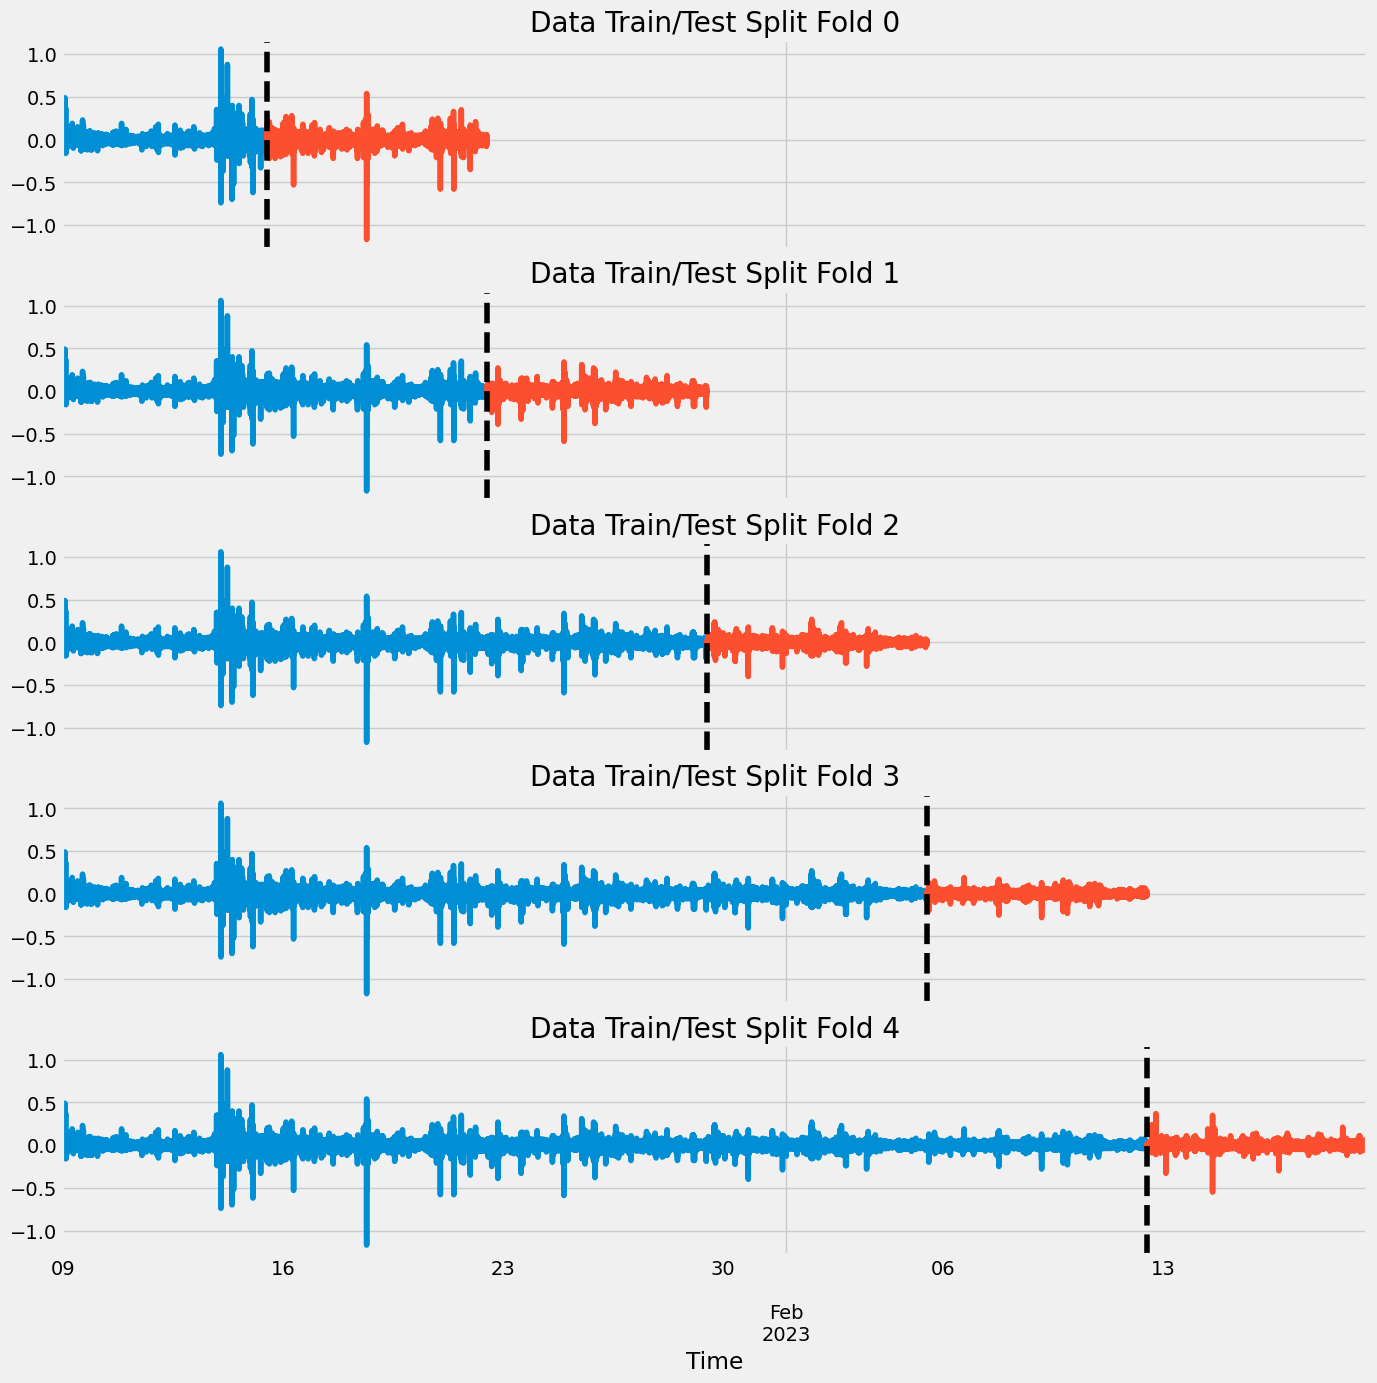

In [24]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=7*24*60)
data = data.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]
    train['Target'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Target'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [37]:
FEATURES = ['Open',
    'High',
    'Low',
    'Volume',
    'RSI_2',
    'SMA_20',
    'RSI_4',
    'SMA_40',
    'RSI_6',
    'SMA_60',
    'RSI_8',
    'SMA_80']
TARGET = 'Target'

## Train using CV

In [59]:
tss = TimeSeriesSplit(n_splits=5, test_size=3*24*60)
data = data.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[15:48:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.49643	validation_1-rmse:0.49575
[100]	validation_0-rmse:0.18562	validation_1-rmse:0.18304
[200]	validation_0-rmse:0.07771	validation_1-rmse:0.07051
[300]	validation_0-rmse:0.04717	validation_1-rmse:0.03347
[400]	validation_0-rmse:0.04131	validation_1-rmse:0.02450
[500]	validation_0-rmse:0.04037	validation_1-rmse:0.02311
[600]	validation_0-rmse:0.04016	validation_1-rmse:0.02297
[659]	validation_0-rmse:0.04008	validation_1-rmse:0.02296
[15:48:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.49636	validation_1-rmse:0.49645
[100]	validation_0-rmse:0.18531	validation_1-rmse:0.18

In [60]:
print(f'RMSE score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

RMSE score across folds 0.0261
Fold scores:[0.0229590155913538, 0.02916313022780002, 0.025893708207128236, 0.028587283796661735, 0.02391721991717501]


In [63]:
reg = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
reg.fit(data[FEATURES], data[TARGET],
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[15:49:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.49622	validation_1-rmse:0.49557
[100]	validation_0-rmse:0.18485	validation_1-rmse:0.18282
[200]	validation_0-rmse:0.07582	validation_1-rmse:0.07058
[300]	validation_0-rmse:0.04400	validation_1-rmse:0.03412
[400]	validation_0-rmse:0.03768	validation_1-rmse:0.02548
[500]	validation_0-rmse:0.03668	validation_1-rmse:0.02406
[600]	validation_0-rmse:0.03649	validation_1-rmse:0.02385
[700]	validation_0-rmse:0.03639	validation_1-rmse:0.02381
[800]	validation_0-rmse:0.03631	validation_1-rmse:0.02379
[900]	validation_0-rmse:0.03623	validation_1-rmse:0.02378
[999]	validation_0-rmse:0.03614	validation_1-rmse:0.02377


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [64]:
y_pred = reg.predict(data[FEATURES])
score = r2_score(data[TARGET].values, y_pred)
print(score)

0.054428472485202106


In [57]:
y_pred

array([ 0.01017421,  0.01059893,  0.01082131, ...,  0.00047217,
       -0.0007667 , -0.0007667 ], dtype=float32)

In [58]:
data[TARGET].values

array([-0.01, -0.02,  0.02, ...,  0.02,  0.  , -0.01])

In [1]:
import yaml
config_file = "config.yaml"
try: 
    with open (config_file, 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')

Error reading the config file


In [3]:
# with open('config.yaml') as f:
#     d = yaml.safe_load(f.read())

# print(d)

with open('config.yaml') as f: 
    yaml_data = yaml.load(f, Loader=yaml.FullLoader)

# type(yaml_data['model_name']['LightGBM']['parameters']['n_estimators'])
yaml_data

{'model_name': {'LightGBM': {'parameters': {'n_estimators': ('int', 50, 1000),
    'learning_rate': ('float', 0.01, 0.3),
    'num_leaves': ('int', 20, 3000, 20),
    'max_depth': ('int', 3, 12),
    'min_data_in_leaf': ('int', 200, 10000, 100),
    'lambda_l1': ('int', 0, 100, 5),
    'lambda_l2': ('int', 0, 100, 5),
    'min_gain_to_split': ('float', 0, 15),
    'bagging_fraction': ('float', 0.2, 0.95, 0.1),
    'bagging_freq': ('cat', [1]),
    'feature_fraction': ('float', 0.2, 0.95, 0.1)}},
  'XGBoost': {'parameters': {'max_depth': ('int', 3, 12),
    'learning_rate': ('float', 0.01, 0.3),
    'n_estimators': ('int', 50, 500),
    'min_child_weight': ('int', 1, 10),
    'gamma': ('log', '1e-8', 1.0),
    'subsample': ('log', 0.01, 1.0),
    'colsample_bytree': ('log', 0.01, 1.0),
    'reg_alpha': ('log', '1e-8', 1.0),
    'reg_lambda': ('log', '1e-8', 1.0),
    'eval_metric': 'mlogloss',
    'use_label_encoder': False}}}}

In [ ]:
param_grid = {
    # "device_type": trial.suggest_categorical("device_type", ['gpu']),
    "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
    "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
    "max_depth": trial.suggest_int("max_depth", 3, 12),
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
    "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
    "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
    "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
    "bagging_fraction": trial.suggest_float(
        "bagging_fraction", 0.2, 0.95, step=0.1
    ),
    "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
    "feature_fraction": trial.suggest_float(
        "feature_fraction", 0.2, 0.95, step=0.1
    ),
}

In [34]:
params_dict = {"best_parameters": { 'num_epochs': 5000, 'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'Adam' }}

In [40]:
with open('best_parameters.yaml', 'w') as outfile: 
    yaml.dump(params_dict, outfile, default_flow_style=False)

In [4]:
import os
SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
sys.path.append(os.path.dirname(SCRIPT_DIR))

NameError: name '__file__' is not defined

In [8]:
from pathlib import Path
path = Path("/home/kenny/algotrading/model_training")
print(os.path.join(path.parent.absolute(), 'backtesting'))

/home/kenny/algotrading/backtesting


In [1]:
import pandas as pd
from model import *
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('data.csv')
df.set_index("Time", inplace=True)
model = Model(df, model_name="RandomForest", task_type="classification")

/home/kenny/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model.indicators_calc()
model.create_target()
model.optimize('/home/kenny/algotrading/model_training/optimization_results')

  0%|          | 0/4 [00:00<?, ?it/s][I 2023-02-20 11:15:48,433] A new study created in memory with name: classification RandomForest with metric - log_loss
[I 2023-02-20 11:17:30,411] Trial 0 finished with value: 17.718459278533505 and parameters: {'RandomForest_max_depth': 7, 'RandomForest_n_estimators': 254, 'RandomForest_min_samples_split': 8, 'RandomForest_min_samples_leaf': 2}. Best is trial 0 with value: 17.718459278533505.
[W 2023-02-20 11:18:22,773] Trial 1 failed with parameters: {'RandomForest_max_depth': 7, 'RandomForest_n_estimators': 319, 'RandomForest_min_samples_split': 16, 'RandomForest_min_samples_leaf': 14} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/kenny/miniconda3/envs/algotrading/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/home/kenny/algotrading/model_training/objective.py", line 76, in _objective
    model_loaded.fit(X_train, 

KeyboardInterrupt: 

In [3]:
{'Extra Trees': {'n_estimators': ('suggest_int', ('Extra Trees_n_estimators', 15, 35)), 'max_depth': ('suggest_discrete_uniform', ('Extra Trees_max_depth', 15, 35, 5)), 'random_state': 128}, 'svr': {'C': ('suggest_loguniform', ('svr_C', 1.0, 100.0)), 'epsilon': ('suggest_uniform', ('svr_epsilon', 0.1, 10.0))}}

{'Extra Trees': {'n_estimators': ('suggest_int',
   ('Extra Trees_n_estimators', 15, 35)),
  'max_depth': ('suggest_discrete_uniform',
   ('Extra Trees_max_depth', 15, 35, 5)),
  'random_state': 128},
 'svr': {'C': ('suggest_loguniform', ('svr_C', 1.0, 100.0)),
  'epsilon': ('suggest_uniform', ('svr_epsilon', 0.1, 10.0))}}

In [3]:
{'LightGBM': {'n_estimators': ('suggest_int', ('LightGBM_n_estimators', 50, 1000)), 'learning_rate': ('suggest_float', ('LightGBM_learning_rate', 0.01, 0.3)), 'num_leaves': ('suggest_int', ('LightGBM_num_leaves', 20, 3000, 20)), 'max_depth': ('suggest_int', ('LightGBM_max_depth', 3, 12)), 'min_data_in_leaf': ('suggest_int', ('LightGBM_min_data_in_leaf', 200, 10000, 100)), 'lambda_l1': ('suggest_int', ('LightGBM_lambda_l1', 0, 100, 5)), 'lambda_l2': ('suggest_int', ('LightGBM_lambda_l2', 0, 100, 5)), 'min_gain_to_split': ('suggest_float', ('LightGBM_min_gain_to_split', 0, 15)), 'bagging_fraction': ('suggest_float', ('LightGBM_bagging_fraction', 0.2, 0.95, 0.1)), 'bagging_freq': ('suggest_categorical', ('LightGBM_bagging_freq', [1])), 'feature_fraction': ('suggest_float', ('LightGBM_feature_fraction', 0.2, 0.95, 0.1))}}

{'LightGBM': {'n_estimators': ('suggest_int',
   ('LightGBM_n_estimators', 50, 1000)),
  'learning_rate': ('suggest_float', ('LightGBM_learning_rate', 0.01, 0.3)),
  'num_leaves': ('suggest_int', ('LightGBM_num_leaves', 20, 3000, 20)),
  'max_depth': ('suggest_int', ('LightGBM_max_depth', 3, 12)),
  'min_data_in_leaf': ('suggest_int',
   ('LightGBM_min_data_in_leaf', 200, 10000, 100)),
  'lambda_l1': ('suggest_int', ('LightGBM_lambda_l1', 0, 100, 5)),
  'lambda_l2': ('suggest_int', ('LightGBM_lambda_l2', 0, 100, 5)),
  'min_gain_to_split': ('suggest_float',
   ('LightGBM_min_gain_to_split', 0, 15)),
  'bagging_fraction': ('suggest_float',
   ('LightGBM_bagging_fraction', 0.2, 0.95, 0.1)),
  'bagging_freq': ('suggest_categorical', ('LightGBM_bagging_freq', [1])),
  'feature_fraction': ('suggest_float',
   ('LightGBM_feature_fraction', 0.2, 0.95, 0.1))}}

NameError: name 'model_training' is not defined